In [1]:
#import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The cross section data is extracted from ArcGIS Pro using the following steps:
1. Delineate (secondary) channel polygon using the Contour tool with the lidar data as input.
2. Convert polygon to centerline using "Polygon To Centerline (Topographic Production)" tool.
3. Create evenly spaced transects along the centerline using the "Generate Transects Along Lines (Data Management)" tool.
4. Create evenly spaced points along the transect line using the "Points Along Line" tool. 
5. Sample lidar elevation on the points using the "Extract Multi Values to Points (Spatial Analyst)" tool. 
6. Export the point shapefile as a CSV. The file should have the following columns: FID (associated with the transect ID), LEN (giving the distance along a transect) and the elevation.

In [3]:
#read cross section data
crosssection_data = pd.read_excel(r'D:\AllertonPark_SecondaryChannels\bankfull_geometry\present_attempt_works\hobo14\hobo14_data.xlsx')
print(crosssection_data)

       ORIG_FID  ORIG_LEN   Elev_m  ORIG_SEQ
0             0      0.00  196.368         1
1             0      0.76  195.685         2
2             0      1.52  195.332         3
3             0      2.28  194.659         4
4             0      3.04  194.379         5
...         ...       ...      ...       ...
16300       125     97.28  192.697       129
16301       125     98.04  192.675       130
16302       125     98.80  192.646       131
16303       125     99.56  192.706       132
16304       125    100.00  192.593       133

[16305 rows x 4 columns]


The following cell defines various functions to 
1. create arrays of potential water surface elevations
2. extract bed elevations
3. find end points (x and y) for each water surface elevation on a transect
4. produce a list of all end points (x and y) for left and right bank

In [7]:
#%% define functions
def wse(y,n):
    "creates an array of water surface elevations"
    min_value = 1.001*np.min(y)
    max_value = 0.99*np.max(y)
    wse = np.linspace(min_value, max_value, n)
    return wse

def add_rect(x,y):
    "adds extra rectangular area to each transect to increase the maximum elevation of the WSE array"
    "del_y and y_upper_num can be tweaked based on the channel size"
    crosssection_df = pd.DataFrame({'Dist': x, 'Elev': y})
    del_y = 3
    y_upper_num = 50
    leftbank_y = np.linspace(y[0]+del_y, y[0], y_upper_num)
    leftbank_x = np.repeat(x[0], len(leftbank_y))
    LB_upper_cs = pd.DataFrame({'Dist': leftbank_x, 'Elev': leftbank_y})
    CS_upper = pd.concat([LB_upper_cs, crosssection_df]).reset_index(drop=True)

    y_lower_num = 50
    rightbank_y = np.linspace(y[-1], y[-1]+del_y, y_upper_num)
    rightbank_x = np.repeat(x[-1], len(rightbank_y))
    RB_lower_cs = pd.DataFrame({'Dist': rightbank_x, 'Elev': rightbank_y})
    CS_lower = pd.concat([CS_upper, RB_lower_cs]).reset_index(drop=True)
    x_final = CS_lower['Dist']
    y_final = CS_lower['Elev']
    
    return x_final, y_final

def long_profile(data, num_average):
    "extracts the average elevation value from the lowest num_average pixels"
    "input dataframe with x and y"
    min_n = data.nsmallest(num_average, ['Y'])
    BedElevation_value = min_n['Y'].mean()
    return BedElevation_value 

def find_endpoints(data, elevation):
    "this function splits the transect into left and right bank based on the location of the minimum"
    "elevation and finds the intersection of the WSE and the transect x and y"
    "input is a dataframe with x and y and an elevation value from the wse array"
    # Initialize a list to store the x-coordinates of intersections
    intersection_points = []

    # Iterate through the irregular line
    for i in range(len(data) - 1):
        x1, y1 = data.iloc[i]
        x2, y2 = data.iloc[i + 1]

        # Check if the horizontal line intersects the current line segment
        if y1 <= elevation <= y2 or y2 <= elevation <= y1:
            # Calculate the x-coordinate of the intersection point using linear interpolation
            x_intersection = x1 + (x2 - x1) * (elevation - y1) / (y2 - y1)
            intersection_points.append(x_intersection)

    x_middle = data.iloc[data['Y'].idxmin()]['X']

    # Find the indices where x_middle would be inserted (left and right)
    left_index = np.searchsorted(intersection_points, x_middle, side='left')
    right_index = np.searchsorted(intersection_points, x_middle, side='right')

    # Get the intersection points just lower and just higher
    left_endpoint = intersection_points[left_index - 1] if left_index > 0 else None
    right_endpoint = intersection_points[right_index] if right_index < len(intersection_points) else None

    return left_endpoint, right_endpoint

def process_channel_data(data):
    [x_f, y_f] = add_rect(data['X'].values, data['Y'].values) 
    data_f = pd.DataFrame({'X': x_f, 'Y': y_f})
    
    min_location = data_f['Y'].idxmin()
    left_bank = data_f.iloc[:min_location + 1]
    right_bank = data_f.iloc[min_location + 1:]

    elevations = wse(data_f['Y'], 500)

    # Initialize lists to store the left and right endpoints
    left_endpoints = []
    right_endpoints = []
    
    # Iterate over elevations and find endpoints
    for elevation in elevations:
        left_endpoint, right_endpoint = find_endpoints(data_f, elevation)
        left_endpoints.append(left_endpoint)
        right_endpoints.append(right_endpoint)
    
    end_points = {
        'LEP': left_endpoints,
        'REP': right_endpoints,
        'WSE': elevations
    }

    end_points_df = pd.DataFrame(end_points)
    end_points_df['width'] = end_points_df['REP'] - end_points_df['LEP']
    end_points_df['height'] = end_points_df['WSE'] - data_f['Y'].min()
    end_points_df['wdratio'] = end_points_df['width'] / end_points_df['height']
    end_points_df['area'] = 0.5 * (end_points_df['width'] + end_points_df['width'].iloc[0]) * end_points_df['height']
    # Filter out rows with negative width
    end_points_df_filtered = end_points_df.loc[end_points_df['width'] > 0].reset_index(drop=True)
    return end_points_df_filtered


The following code block processes all the transects and outputs six potential values of bankfull dimensions, while also producing figures for all transects similar to Fig. 4 in the manuscript. the figures are helpful in interpreting the correct bankfull elevation.  

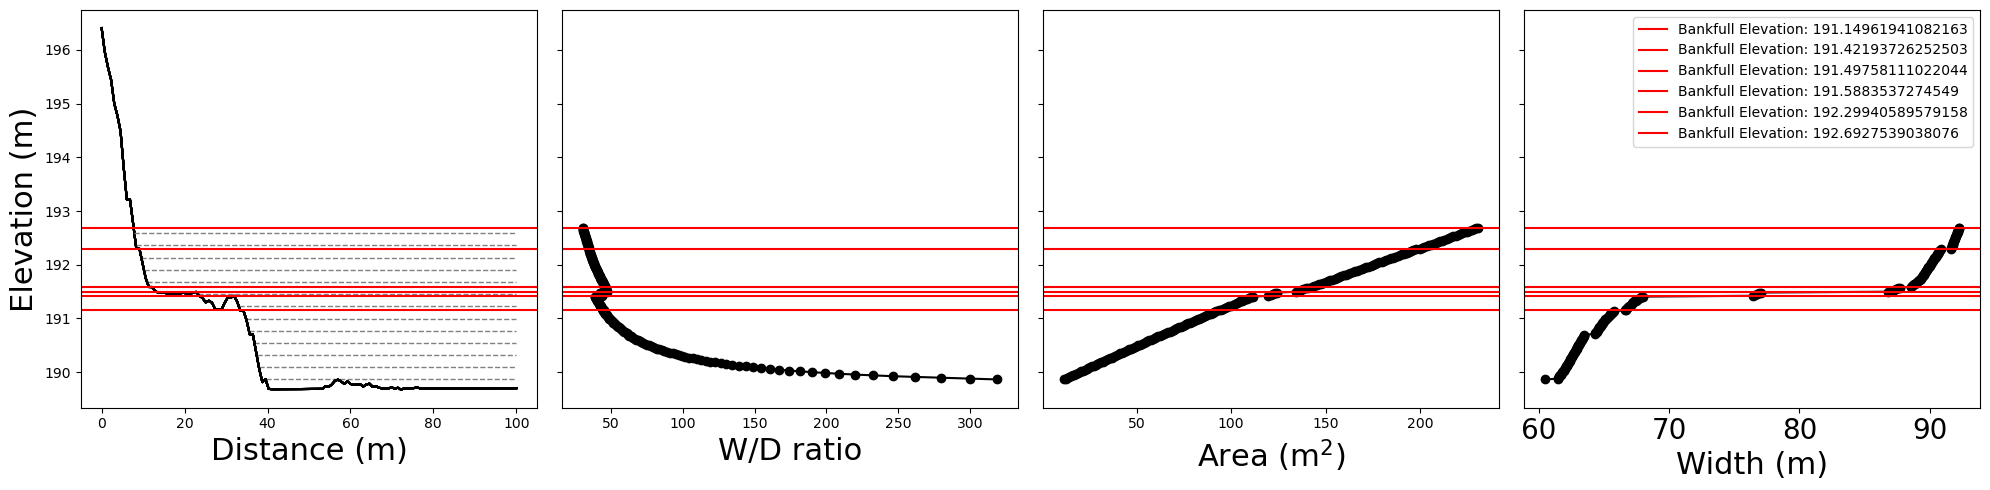

1


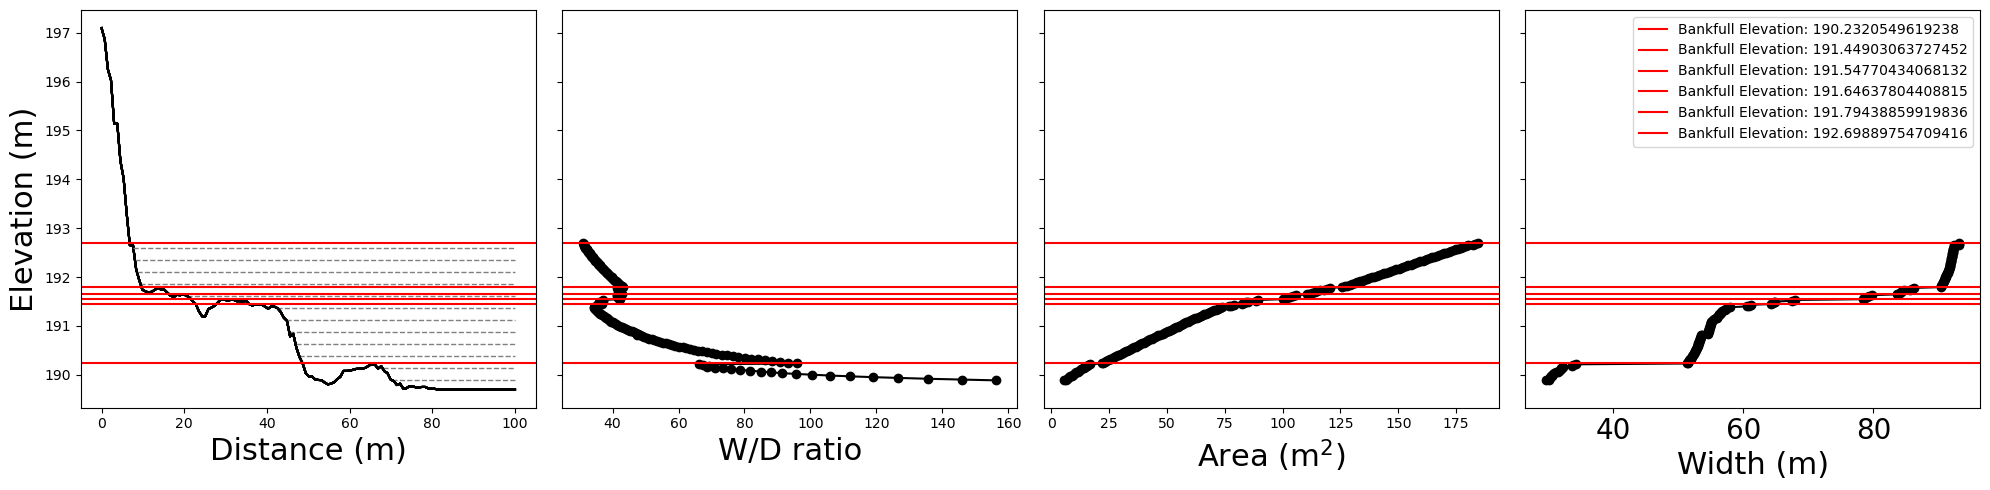

2


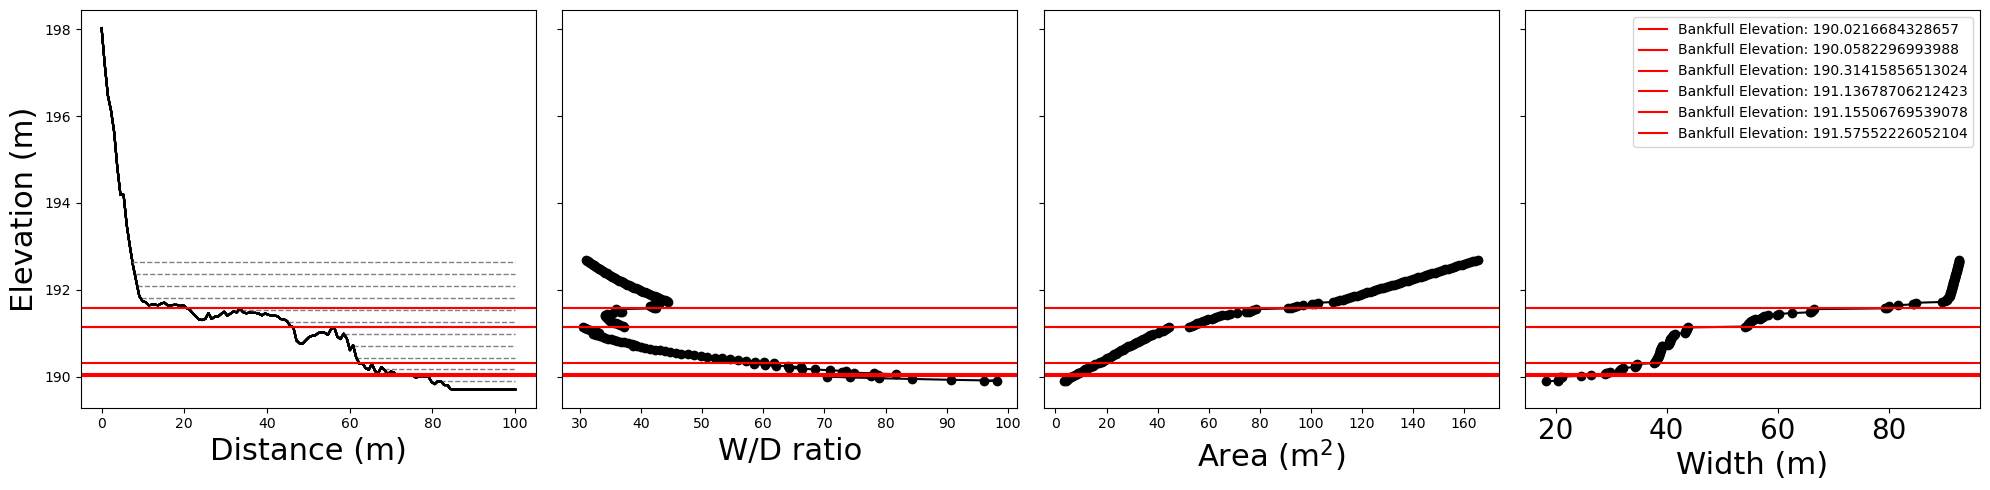

3


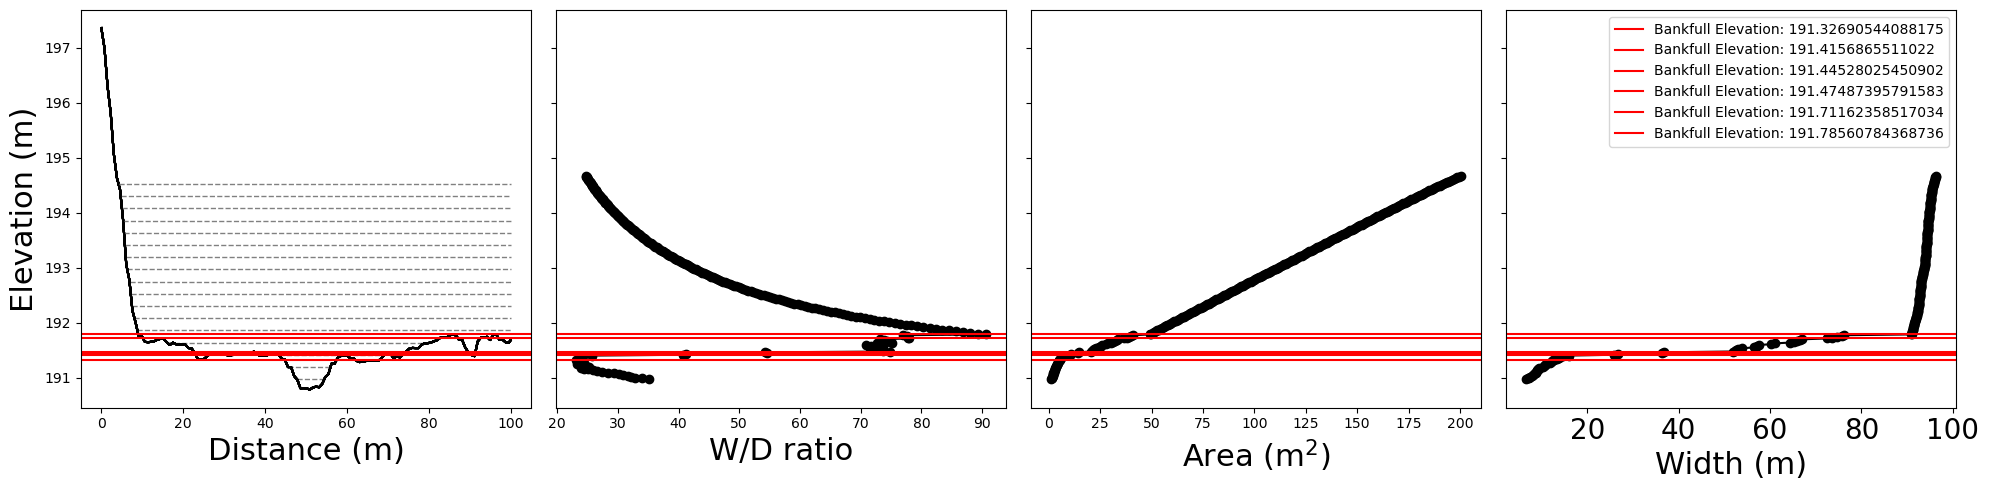

4


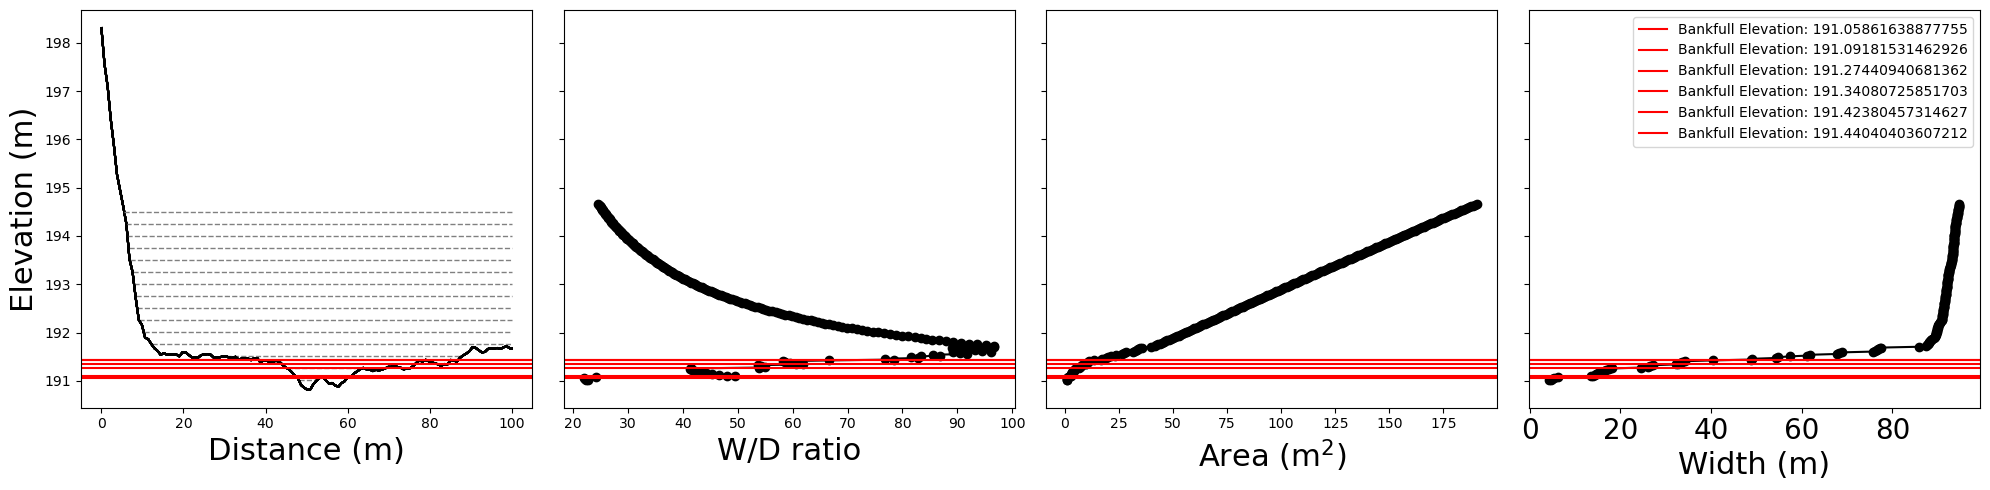

5


KeyboardInterrupt: 

In [10]:
#%% MAIN LOOP all potential values
n_transects = max(crosssection_data['ORIG_FID'])
folder_path = r'D:\AllertonPark_SecondaryChannels\bankfull_geometry\present_attempt_works\hobo14\figures'

# initialize bankfull data lists (elevation and width) that produces six potential values
bankfull_elevations = np.zeros((n_transects, 6))
bankfull_widths = np.zeros((n_transects, 6))
bed_elevations = np.zeros((n_transects, 1)) 

# Loop through transects
for i in range(1, n_transects):
    # Extract data for the current transect
    data = crosssection_data[crosssection_data['ORIG_FID'] == i]
    data.columns = ['ID', 'X', 'Y', '#']

    # Calculate bed elevation
    bed_elevations[i] = long_profile(data, 2)

    # Process channel data and calculate bankfull properties
    bankfull_properties = process_channel_data(data)
    bankfull_properties['width_diff'] = bankfull_properties['width'].diff()
    bankfull_properties['wdratio_diff'] = bankfull_properties['wdratio'].diff()

    # Check if bankfull_properties is not empty
    if not bankfull_properties.empty:
        # Find indices of smallest wdratio values
        potential_bf_indices = bankfull_properties['wdratio_diff'].nlargest(5).index
        min_wdratio_index = bankfull_properties['wdratio'].idxmin()
        final_bf_indices = potential_bf_indices.append(pd.Index([min_wdratio_index]))
        potential_bankfull_data = bankfull_properties.loc[final_bf_indices]
        potential_bankfull_data.sort_index(ascending=True, inplace=True)
        bankfull_elevations[i,:] = potential_bankfull_data['WSE']
        potential_bankfull_widths_indices = final_bf_indices-1
        potential_bankfull_widths_indices = [idx if idx != -1 else 0 for idx in potential_bankfull_widths_indices]
        potential_bankfull_widths = bankfull_properties.loc[potential_bankfull_widths_indices]
        potential_bankfull_widths.sort_index(ascending=True, inplace=True)
        bankfull_widths[i,:] = potential_bankfull_widths['width']
                # Plot 1x4 subplot of cross section bankfull properties
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        
        # Create a subset of the DataFrame by selecting every 20th row
        subset_df = bankfull_properties.iloc[::15]
        
        # Transect plot with WSEs
        ax = axes[0]
        for index, row in subset_df.iterrows():
            lep = row['LEP']
            rep = row['REP']
            wse_val = row['WSE']
            ax.plot(data['X'], data['Y'], color='black')
            ax.plot([lep, rep], [wse_val, wse_val], linestyle='--', color='gray', linewidth=1, label=f'Point {index + 1}')
        ax.set_xlabel('Distance (m)', fontsize=22)
        ax.set_ylabel('Elevation (m)', fontsize=22)
        # Add horizontal lines at all WSE values
        for wse_val in potential_bankfull_data['WSE']:
            ax.axhline(y=wse_val, color='red', linestyle='-', linewidth=1.5, label=f'Bankfull Elevation: {wse_val}')
        
        # WSE vs wdratio
        ax = axes[1]
        ax.plot(bankfull_properties['wdratio'], bankfull_properties['WSE'], marker='o', linestyle='-', color='black')
        ax.set_xlabel('W/D ratio', fontsize=22)
        # Add horizontal lines at all WSE values
        for wse_val in potential_bankfull_data['WSE']:
            ax.axhline(y=wse_val, color='red', linestyle='-', linewidth=1.5, label=f'Bankfull Elevation: {wse_val}')
        
        # WSE vs area
        ax = axes[2]
        ax.plot(bankfull_properties['area'], bankfull_properties['WSE'], marker='o', linestyle='-', color='black')
        ax.set_xlabel('Area (m$^2$)', fontsize=22)
        # Add horizontal lines at all WSE values
        for wse_val in potential_bankfull_data['WSE']:
            ax.axhline(y=wse_val, color='red', linestyle='-', linewidth=1.5, label=f'Bankfull Elevation: {wse_val}')
        
        # Width vs WSE
        ax = axes[3]
        ax.plot(bankfull_properties['width'], bankfull_properties['WSE'], marker='o', linestyle='-', color='black')
        ax.set_xlabel('Width (m)', fontsize=22)
        # Add horizontal lines at all WSE values
        for wse_val in potential_bankfull_data['WSE']:
            ax.axhline(y=wse_val, color='red', linestyle='-', linewidth=1.5, label=f'Bankfull Elevation: {wse_val}')
        
        # Add legend only for the last subplot
        ax.legend()
        ax.tick_params(axis='both', labelsize=20)
        # Adjust layout for better visibility
        plt.tight_layout()
        
        # Save or display the plot
        # filename = os.path.join(folder_path, f'subplot_transect_{i}.pdf')
        # plt.savefig(filename, dpi=300, transparent=False)
        plt.show()

    else:
        bankfull_elevations[i,:] = np.nan
        bankfull_widths[i,:] = np.nan

    
    print(i)